In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
#import seaborn as sns
#import datetime
#from datetime import datetime, timedelta
import datetime
import re
import scipy.io
from netCDF4 import Dataset
import netCDF4
import sys
import numpy.ma as ma
%matplotlib inline 

In [2]:
import seaborn as sns
sns.set_style('ticks')

In [3]:
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['figure.figsize'] = (4,3)

In [4]:
pcolors_d3 = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']
#https://github.com/d3/d3-3.x-api-reference/blob/master/Ordinal-Scales.md#category10

In [7]:
def write2nc(center, iso_mat, fac=228.82):

    #f = netCDF4.Dataset('romi_'+center+'.nc', 'w')
    with netCDF4.Dataset('romi_'+center+'.nc', 'w') as f:
        
        nt = iso_mat['iso_fcst'].shape[1]
        for i in np.arange(iso_mat['iso_fcst'].shape[1]):
            if all(iso_mat['iso_fcst'][:,i,0,0] == 0):
                nt = i
                break

        nens = iso_mat['iso_fcst'].shape[-1]

        f.createDimension('lead', size=nt)
        f.createDimension('member', size=nens)
        f.createDimension('ForecastID', size=iso_mat['iso_fcst'].shape[0])

        a = f.createVariable('lead', 'f',('lead',))
        a.setncattr('longname', 'forecast lead in days')
        f.createVariable('member', np.int,('member',))
        a = f.createVariable('ForecastID', np.int,('ForecastID'))
        a.setncattr('longname', 'Forecast initialization date')
        adim = f.createVariable('ModelVersion', np.int, ('ForecastID'))
        adim.setncattr('longname', 'Forecast model version')

    
    
        f.createVariable('PC1', np.float32,('ForecastID','lead', 'member' ))
        f.createVariable('PC2', np.float32,('ForecastID','lead', 'member'))
        f.createVariable('PC1veri', np.float32,('ForecastID','lead', ))
        f.createVariable('PC2veri', np.float32,('ForecastID','lead', ))

        f.variables['lead'][:] = np.arange(nt)
        f.variables['member'][:] = np.arange(nens)

        nf = iso_mat['time'].shape[0]
        ftime = np.array([int(datetime.datetime.fromordinal(int(iso_mat['time'][i,0])).strftime('%Y%m%d')) for i in np.arange(nf)])
        #f.variables['ForecastID'][:] = iso_mat['time'][:,0]
        f.variables['ForecastID'][:] = ftime
        #f.variables['ForecastID'][:] = iso_mat['time'][:,0]


        vtime = np.array([int(datetime.datetime.fromordinal(int(iso_mat['model_version_time'][0,i])).strftime('%Y%m%d')) for i in np.arange(nf)])
        f.variables['ModelVersion'][:] = vtime

        tmp1 = iso_mat['iso_fcst'][:,:nt,0,:].squeeze()/fac
        f.variables['PC1'][:] = tmp1.astype(np.float32)
        
        tmp2 = iso_mat['iso_fcst'][:,:nt,1,:].squeeze()/fac
        f.variables['PC2'][:] = tmp2.astype(np.float32)

        f.variables['PC1veri'][:] = iso_mat['iso_veri'][:,:nt,0].squeeze()/fac
        f.variables['PC2veri'][:] = iso_mat['iso_veri'][:,:nt,1].squeeze()/fac

    #f.close()


In [8]:
fac = 228.82
center_list = [ 'ecmf', 'ncep', 'jma',   'cma', 'cnrm', 'eccc', 'hmcr', 'bom',     'ukmo', 'isac']
for i, center in enumerate(center_list):
    iso_mat = scipy.io.loadmat('/sw19/wangs/s2s_post/olr_20S20N/omi_calc_save_modelversion_9pt/version2/omi_index_' + center +'.mat')
    
    iso_mat['iso_veri'].shape, iso_mat['iso_fcst'].shape
    ini_time = [datetime.datetime.fromordinal(int(tt)) for tt in iso_mat['time'][:,0]]
    ini_month = np.array([tt.month for tt in ini_time])
    ini_year = np.array([tt.year for tt in ini_time])
    
    omi_1 = iso_mat['iso_veri'][:, 0, 0]/fac
    omi_2 = iso_mat['iso_veri'][:, 0, 1]/fac
    pha = np.arctan2(-omi_1, omi_2);
    omi_ini_phase = np.floor((pha+np.pi)/(np.pi/4)) +1 
    
    write2nc(center, iso_mat, fac=228.82)
        
print(iso_mat.keys())    

dict_keys(['iso_veri', 'model_version_time', '__globals__', 'iso_fcst', '__version__', '__header__', 'time'])


In [9]:
print(iso_mat.keys())

dict_keys(['iso_veri', 'model_version_time', '__globals__', 'iso_fcst', '__version__', '__header__', 'time'])


In [10]:
omi_ini_phase.shape

(2188,)

In [11]:
center = 'ecmf'
iso_mat = scipy.io.loadmat('/sw19/wangs/s2s_post/olr_20S20N/omi_calc_save_modelversion_9pt/version2/omi_index_' + center +'.mat')
fac = 228.82

In [15]:
parameters = {'a':1.0, 'b':2.0, 'c':3.0}
f = netCDF4.Dataset('test.nc', 'w')
parms = f.createGroup('parameters')
for k,v in parameters.items():
    setattr(parms, k, v)
f.close()    

In [16]:
f = netCDF4.Dataset('test.nc', 'w')
parms = f.createGroup('parameters')
for k,v in iso_mat.items():
    setattr(parms, k, v)
f.close()    

In [18]:
iso_mat.keys(), iso_mat['iso_fcst'].shape

(dict_keys(['iso_veri', 'model_version_time', '__globals__', 'iso_fcst', '__version__', '__header__', 'time']),
 (5524, 60, 2, 11))

In [20]:
#f.close()
with netCDF4.Dataset('test.nc', 'w') as f:
    nf, nt, _, nens = iso_mat['iso_fcst'].shape
    for i in np.arange(iso_mat['iso_fcst'].shape[1]):
        if all(iso_mat['iso_fcst'][:,i,0,0] == 0):
            nt = i
            break
    nens = iso_mat['iso_fcst'].shape[-1]
    print(nt, nens)
    
    f.createDimension('lead', size=nt)
    f.createDimension('member', size=nens)
    f.createDimension('ForecastID', size=nf)

    a = f.createVariable('lead', 'f',('lead',))
    a.setncattr('longname', 'forecast lead in days')
    f.createVariable('member', np.int,('member',))
    
    a = f.createVariable('ForecastID', np.int,('ForecastID'))
    a.setncattr('longname', 'Forecast initialization date')

        
    adim = f.createVariable('ModelVersion', np.int, ('ForecastID'))
    adim.setncattr('longname', 'Forecast model version')
    
    f.createVariable('PC1', np.float32,('ForecastID','lead', 'member' ))
    f.createVariable('PC2', np.float32,('ForecastID','lead', 'member'))
    f.createVariable('PC1veri', np.float32,('ForecastID','lead', ))
    f.createVariable('PC2veri', np.float32,('ForecastID','lead', ))

    f.variables['lead'][:] = np.arange(nt)
    f.variables['member'][:] = np.arange(nens)

    nf = iso_mat['time'].shape[0]
    ftime = np.array([int(datetime.datetime.fromordinal(int(iso_mat['time'][i,0])).strftime('%Y%m%d')) for i in np.arange(nf)])
    #f.variables['ForecastID'][:] = iso_mat['time'][:,0]
    f.variables['ForecastID'][:] = ftime

    vtime = np.array([int(datetime.datetime.fromordinal(int(iso_mat['model_version_time'][0,i])).strftime('%Y%m%d')) for i in np.arange(nf)])
    f.variables['ModelVersion'][:] = vtime


    tmp1 = iso_mat['iso_fcst'][:,:nt,0,:].squeeze()/fac
    f.variables['PC1'][:] = tmp1.astype(np.float32)
    tmp2 = iso_mat['iso_fcst'][:,:nt,1,:].squeeze()/fac
    f.variables['PC2'][:] = tmp2.astype(np.float32)

    f.variables['PC1veri'][:] = iso_mat['iso_veri'][:,:nt,0].squeeze()/fac
    f.variables['PC2veri'][:] = iso_mat['iso_veri'][:,:nt,1].squeeze()/fac

#f.close()

46 11


In [21]:
iso_mat['iso_fcst'].shape

(5524, 60, 2, 11)

In [22]:
write2nc('test', iso_mat)

# now we do some check 

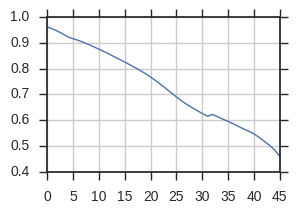

In [23]:
center = 'ecmf'
#with netCDF4.Dataset('rmm_nc/romi_'+center+'.nc', 'r') as f:
with netCDF4.Dataset('test.nc', 'r') as f:    
    romi1_f = f.variables['PC1'][:]
    romi2_f = f.variables['PC2'][:]
    romi1_v = f.variables['PC1veri'][:]
    romi2_v = f.variables['PC2veri'][:]
    ftime = f.variables['ForecastID'][:] 
    mtime = f.variables['ModelVersion'][:] 
    
initime = [datetime.datetime.strptime(str(f), '%Y%m%d') for f in ftime ]
ini_month = np.array([t.month for t in initime])
ini_year = np.array([t.year for t in initime])

isel = np.where( ((ini_month>=12)|(ini_month<=3))&(ini_year>=1999) & (ini_year<=2010) & (mtime > 20150601) )[0]
isel =  ((ini_month>=12)|(ini_month<=3))&(ini_year>=1999) & (ini_year<=2010) #& (mtime > 20150601)  

nt = romi1_v.shape[-1]
acc0 = np.zeros(nt)
acc1 = np.zeros(nt)

for i in np.arange(nt):
    tmp1 = np.hstack((romi1_f[isel,i,:].mean(-1), romi2_f[isel,i,:].mean(-1)))
    tmp2 = np.hstack((romi1_v[isel,i], romi2_v[isel,i]))
    acc0[i] = np.corrcoef(tmp1, tmp2)[0,1]

    ff1 = romi1_f[isel,i,:].mean(-1)
    ff2 = romi2_f[isel,i,:].mean(-1)

    vv1 = romi1_v[isel,i]
    vv2 = romi2_v[isel,i]
    num = np.sum(ff1*vv1) + np.sum(ff2*vv2)
    den = np.sqrt(np.sum(ff1**2+ff2**2))*np.sqrt(np.sum(vv1**2+vv2**2))
    acc1[i] = num/den

plt.figure(figsize=(3,2))
plt.plot(acc1)
plt.grid()

In [38]:
ftime.shape, ftime2.shape

NameError: name 'ftime2' is not defined

In [36]:
center = 'ecmf'
iso_mat = scipy.io.loadmat('/sw19/wangs/s2s_post/olr_20S20N/omi_calc_save_modelversion_9pt/version2/omi_index_' + center +'.mat')
Nfcst, Nt, _, Nens = iso_mat['iso_fcst'].shape

nens = 11
if center == 'ecmf' :
    iso_amp_fcst = np.sqrt( iso_mat['iso_fcst'][:,:,0,:]**2 + iso_mat['iso_fcst'][:,:,1,:]**2  )/fac
    isel = np.arange(iso_mat['iso_fcst'].shape[0])
    isel = []
    for ii in np.arange(Nfcst):
        if  iso_amp_fcst[ii,32:, 5:].sum(-1).sum(-1) > 0 :               
            isel.append(ii)
    isel = np.array(isel)   
    iso_fcst = iso_mat['iso_fcst'][isel,:,:,:nens]
    iso_veri = iso_mat['iso_veri'][isel,:,:]
    iso_mat.update ({'iso_fcst': iso_fcst, 'iso_veri':iso_veri, 'time':iso_mat['time'][isel,:]})
        
        
ini_time = [datetime.datetime.fromordinal(int(tt)) for tt in iso_mat['time'][:,0]]
ini_month = np.array([tt.month for tt in ini_time])
ini_year = np.array([tt.year for tt in ini_time])

ii = ((ini_month>=12) | (ini_month<=3)) & (ini_year>=1999) & (ini_year<=2010) 
ii = ((ini_month>=12) | (ini_month<=3)) & (ini_year>=1999) & (ini_year<=2010) 
iso_fcst = iso_mat['iso_fcst'][ii,:,:,:nens]
iso_veri = iso_mat['iso_veri'][ii,:,:]
iso_mat.update ({'iso_fcst': iso_fcst, 'iso_veri':iso_veri})
        

acc = np.zeros(46)
for i in np.arange(46):
    ff1 = iso_mat['iso_fcst'][:,i,0,:nens].mean(-1)/fac
    ff2 = iso_mat['iso_fcst'][:,i,1,:nens].mean(-1)/fac
    vv1 = iso_mat['iso_veri'][:,i,0]/fac
    vv2 = iso_mat['iso_veri'][:,i,1]/fac

    ff1  = ma.masked_where(np.abs(ff1) >= 1e3, ff1)
    ff2  = ma.masked_where(np.abs(ff2) >= 1e3, ff2)

    #print(ff1.shape)
    num = np.sum(ff1*vv1) + np.sum(ff2*vv2)
    den = np.sqrt(np.sum(ff1**2+ff2**2))*np.sqrt(np.sum(vv1**2+vv2**2))
    acc[i] = num/den
    if i < 10:
        print(i, num, den, num/den, len(ff1))

0 2004.78 2037.56 0.983912 840
1 1956.07 2003.25 0.976448 840
2 1899.13 1963.06 0.96743 840
3 1837.44 1920.19 0.956907 840
4 1771.36 1874.92 0.944766 840
5 1726.34 1841.57 0.937427 840
6 1684.59 1810.8 0.930299 840
7 1648.48 1786.91 0.922531 840
8 1615.42 1767.45 0.913983 840
9 1583.76 1750.05 0.90498 840


In [32]:
def load_calc_acc_phase_lag(center, season = 'all', nens=100, fac=228):
    if 1 == 11:
        center = 'ecmf'
        #season = 'winter'
    iso_ecmf_mat = scipy.io.loadmat('/sw19/wangs/s2s_post/olr_20S20N/omi_calc_save_modelversion_9pt/version2/omi_index_' + center +'.mat')
    Nfcst, Nt, _, Nens = iso_ecmf_mat['iso_fcst'].shape

    if center == 'ecmf':
        iso_amp_fcst = np.sqrt( iso_ecmf_mat['iso_fcst'][:,:,0,:]**2 + iso_ecmf_mat['iso_fcst'][:,:,1,:]**2  )/fac
        isel = np.arange(iso_ecmf_mat['iso_fcst'].shape[0])
        isel = []
        for ii in np.arange(Nfcst):
            #if (np.sum(iso_ecmf_mat['iso_fcst'][ii,32:]) > 0) and (iso_amp_fcst[ii,32:, 5:].sum(-1).sum(-1) > 0 ) : 
            if  iso_amp_fcst[ii,32:, 5:].sum(-1).sum(-1) > 0 :               
                isel.append(ii)
        isel = np.array(isel)   
        iso_fcst = iso_ecmf_mat['iso_fcst'][isel,:,:,:nens]
        iso_veri = iso_ecmf_mat['iso_veri'][isel,:,:]
        iso_ecmf_mat.update ({'iso_fcst': iso_fcst, 'iso_veri':iso_veri, 'time':iso_ecmf_mat['time'][isel,:]})
        
        
    nens = np.min((Nens, nens))
    
    ini_time = [datetime.datetime.fromordinal(int(tt)) for tt in iso_ecmf_mat['time'][:,0]]
    ini_month = np.array([tt.month for tt in ini_time])
    ini_year = np.array([tt.year for tt in ini_time])

    
    if season == 'all':
        pass
    elif season == 'winter':
        ii = ((ini_month>=12) | (ini_month<=3)) & (ini_year>=1999) & (ini_year<=2010) 
        iso_fcst = iso_ecmf_mat['iso_fcst'][ii,:,:,:nens]
        iso_veri = iso_ecmf_mat['iso_veri'][ii,:,:]
        iso_ecmf_mat.update ({'iso_fcst': iso_fcst, 'iso_veri':iso_veri})
    elif season == 'summer' :
        ii = (ini_month>=6) & (ini_month<=9) & (ini_year>=1999) & (ini_year<=2010) 
        iso_fcst = iso_ecmf_mat['iso_fcst'][ii,:,:,:nens]
        iso_veri = iso_ecmf_mat['iso_veri'][ii,:,:]
        iso_ecmf_mat.update ({'iso_fcst': iso_fcst, 'iso_veri':iso_veri})
        
        

    acc_phase = np.zeros((60, 8))+np.nan
    acc = np.zeros((60))+np.nan
        
    for ilag in np.arange(45) :   
        
        omi_1 = iso_ecmf_mat['iso_veri'][:, ilag, 0]
        omi_2 = iso_ecmf_mat['iso_veri'][:, ilag, 1]
        pha = np.arctan2(-omi_1, omi_2);
        omi_phase = np.floor((pha+np.pi)/(np.pi/4));
        omi_phase += 1



        if 1 == 1:
            i = ilag
        #for i in [ilag]: #np.arange(Nt):
            #  isel =  (iso_ini_month>=5) & (iso_ini_month<=9) & (ini_amp>=r1) & (ini_amp<=r2)   

            ff1 = iso_ecmf_mat['iso_fcst'][:,i,0,:nens].mean(-1)/fac
            ff2 = iso_ecmf_mat['iso_fcst'][:,i,1,:nens].mean(-1)/fac
            vv1 = iso_ecmf_mat['iso_veri'][:,i,0]/fac
            vv2 = iso_ecmf_mat['iso_veri'][:,i,1]/fac

            ff1  = ma.masked_where(np.abs(ff1) >= 1e3, ff1)
            ff2  = ma.masked_where(np.abs(ff2) >= 1e3, ff2)

            #print(ff1.shape)
            num = np.sum(ff1*vv1) + np.sum(ff2*vv2)
            den = np.sqrt(np.sum(ff1**2+ff2**2))*np.sqrt(np.sum(vv1**2+vv2**2))
            acc[i] = num/den

            #if i < 10:
            #    print(i, num, den, acc[i], ff1.shape)

            for iphase in np.arange(8):

                isel = (omi_phase == iphase+1)
                #print(iphase, isel.shape)
                ff1 = iso_ecmf_mat['iso_fcst'][isel,i,0,:nens].mean(-1)
                ff2 = iso_ecmf_mat['iso_fcst'][isel,i,1,:nens].mean(-1)
                vv1 = iso_ecmf_mat['iso_veri'][isel,i,0]
                vv2 = iso_ecmf_mat['iso_veri'][isel,i,1]

                if isel.shape[0] < 1:
                    print('wrong isel')
                num = np.sum(ff1*vv1) + np.sum(ff2*vv2)
                den = np.sqrt(np.sum(ff1**2+ff2**2))*np.sqrt(np.sum(vv1**2+vv2**2))
                acc_phase[i,iphase] = num/den
 


    return acc,  acc_phase

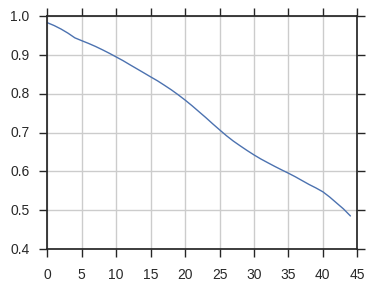

In [39]:
acc_n, acc_phase,  = load_calc_acc_phase_lag('ecmf', season='winter', fac=228.82)  
plt.plot(acc_n)
plt.grid()

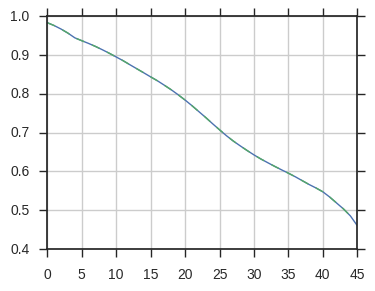

In [41]:
plt.figure(figsize=(4,3))
plt.plot(acc)
plt.plot(acc_n, '--')
plt.grid()

/home/wangs/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:73: RuntimeWarning: invalid value encountered in float_scalars
/home/wangs/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:91: RuntimeWarning: invalid value encountered in float_scalars


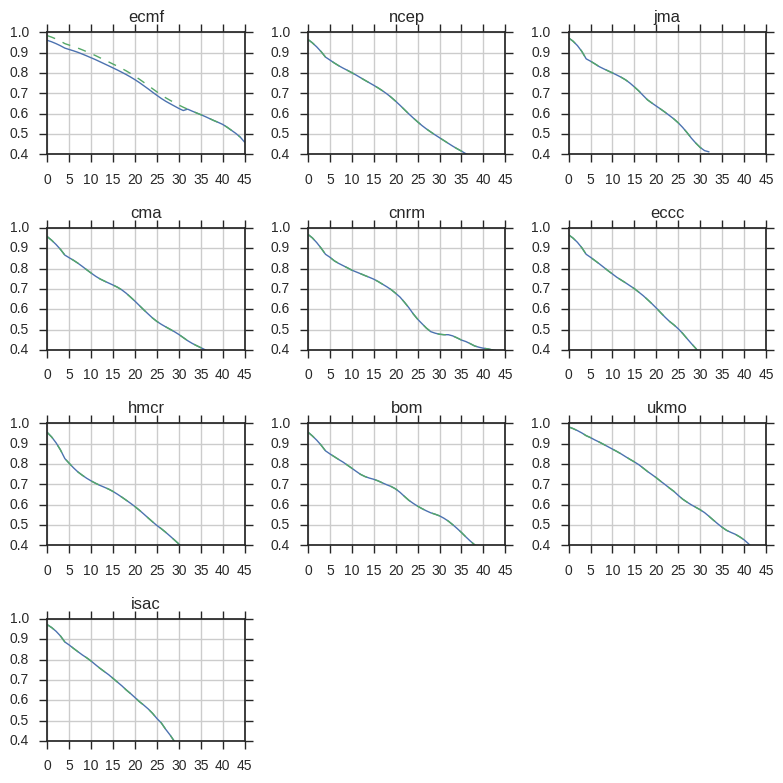

In [34]:
plt.figure(figsize=(8, 8))

for ii, center in enumerate(center_list):
    with netCDF4.Dataset('./romi_'+center+'.nc', 'r') as f:
    #with netCDF4.Dataset('test.nc', 'r') as f:    
        romi1_f = f.variables['PC1'][:]
        romi2_f = f.variables['PC2'][:]
        romi1_v = f.variables['PC1veri'][:]
        romi2_v = f.variables['PC2veri'][:]
        ftime = f.variables['ForecastID'][:] 
        mtime = f.variables['ModelVersion'][:] 
    
    initime = [datetime.datetime.strptime(str(f), '%Y%m%d') for f in ftime ]
    ini_month = np.array([t.month for t in initime])
    ini_year = np.array([t.year for t in initime])

    isel = np.where( ((ini_month>=12)|(ini_month<=3))&(ini_year>=1999) & (ini_year<=2010) & (mtime > 20150601) )[0]
    isel =  ((ini_month>=12)|(ini_month<=3))&(ini_year>=1999) & (ini_year<=2010) #& (mtime > 20150601)  

    nt = romi1_v.shape[-1]
    acc0 = np.zeros(nt)
    acc1 = np.zeros(nt)

    for i in np.arange(nt):
        tmp1 = np.hstack((romi1_f[isel,i,:].mean(-1), romi2_f[isel,i,:].mean(-1)))
        tmp2 = np.hstack((romi1_v[isel,i], romi2_v[isel,i]))
        acc0[i] = np.corrcoef(tmp1, tmp2)[0,1]

        ff1 = romi1_f[isel,i,:].mean(-1)
        ff2 = romi2_f[isel,i,:].mean(-1)

        vv1 = romi1_v[isel,i]
        vv2 = romi2_v[isel,i]
        num = np.sum(ff1*vv1) + np.sum(ff2*vv2)
        den = np.sqrt(np.sum(ff1**2+ff2**2))*np.sqrt(np.sum(vv1**2+vv2**2))
        acc1[i] = num/den

    acc_n, acc_phase,  = load_calc_acc_phase_lag(center, season='winter', fac=228.82)  

    plt.subplot(4,3,ii+1)
    plt.plot(acc1)
    plt.plot(acc_n, '--')
    plt.grid()
    plt.axis([0,45, 0.4, 1])
    plt.title(center, y=1.03)
plt.tight_layout()